In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
import pickle
import seaborn as sns
import multiprocessing

In [2]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
import re

In [3]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params/ffar_mi_params')
from ffar_mi_params_fit import *

In [4]:
# dask cluster location
cluster_loc = 'hpc'
prefix = 'plot'
tuneby = 'Block_Id'
logo_group = 'Block_Id'
use_cuda = False
# set backend as one of 'multiprocessing' or 'dask'
backend = 'dask' 

inDIR = '../data/extractions/'
inFILE = 'ffar-mi-biomass_hls.csv'
nickname = 'ffar_mi'

inPATH = os.path.join(inDIR, inFILE)

outDIR = '../data/modeling/'
with open(os.path.join(outDIR, 'tmp',  'ml_train_' + nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'rb') as f:
    mod_dict = pickle.load(f)

modelDIR = os.path.join('../output/models', nickname)
if not os.path.exists(modelDIR):
    os.path.mkdir(modelDIR)

# unique ID column name
id_col = 'Block_Id'
# date column name
date_col = 'Date'
# dependent variable column
y_col = 'mean_biomass'

save_results = False

var_names = [
    'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7', 'SAVI',
    'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI', 'TCGI', 'TCWI',
    'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246', 'BAI_346',
    'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2'
]

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
#from xgboost import XGBRegressor

import torch
import torch.nn as nn
import torch.optim as optim
import skorch
from skorch import NeuralNetRegressor

import sys
sys.path.insert(1, '../extract')
from hpc_setup import launch_dask
from dnn_setup import ResNetRegressor, ResidualBlock

if backend == 'dask':
    #from dask_ml.xgboost import XGBRegressor
    from dask_ml.model_selection import GridSearchCV
    from sklearn.model_selection import GridSearchCV as skGridSearchCV
else:
    #from xgboost import XGBRegressor
    from sklearn.model_selection import GridSearchCV


In [6]:
def vip(x, y, model):
    t = model.x_scores_
    #w = model.x_weights_
    w = model.x_rotations_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

def r2_corrcoef(y_obs, y_pred):
    corr_matrix = np.corrcoef(y_obs, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    return R_sq

if backend == 'dask':
    import dask
    @dask.delayed
    def fit_ols(all_x, split_groups, df_train, lr_form, group_k, idx):
        r2_adj_tmp = []
        aic_tmp = []
        mae_orig_tmp = []
        for train_index_sub, test_index_sub in mod_logo.split(all_x, groups=split_groups):
            df_train_sub = df_train.iloc[train_index_sub]
            df_test_sub = df_train.iloc[test_index_sub]
            lreg_k_tmp = smf.ols(formula=lr_form, data=df_train_sub).fit()
            r2_adj_tmp.append(lreg_k_tmp.rsquared_adj)
            aic_tmp.append(lreg_k_tmp.aic)
            mae_orig_tmp.append(np.nanmean(np.abs(lreg_k_tmp.predict(df_test_sub) - df_test_sub[y_col])))
        df_results_tmp = pd.DataFrame(dict(group=[group_k],
                                           group_name=[logo_group],
                                           numb_vars=[k_fold],
                                           formula=[lr_form],
                                           R2_adj=round(np.mean(r2_adj_tmp), 4),
                                           AIC=round(np.mean(aic_tmp), 4),
                                           mae_orig_mean=round(np.mean(mae_orig_tmp), 4)),
                                     index=[idx])
        return df_results_tmp

    @dask.delayed
    def fit_dnn(mod_base, batch_start, batch_size, all_x, all_y, loss_fn, optimizer):
        for start in batch_start:
            # take a batch
            X_batch = all_x[start:start+mod_dict[k]['batch_size']]
            y_batch = all_y[start:start+mod_dict[k]['batch_size']]
            # forward pass
            y_pred = mod_base(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
        return mod_base

In [7]:
if backend == 'dask':
    # from ml_setup import fit_ols, fit_dnn
    import ml_setup
    from hpc_setup import launch_dask
    import psutil
    interface_prefs = ['enp24s0f0', 'ens7f0']
    interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
    if len(interface) == 0:
        print('ERROR: Preferred interfaces not found on node!')
    else:
        print(interface)
    num_jobs=16
    client = launch_dask(cluster_loc=cluster_loc, num_jobs=num_jobs, partition='brief-low', slurm_opts={'interface': interface})
    display(client)
    nthreads = len(client.nthreads())
else:
    nthreads = multiprocessing.cpu_count()

enp24s0f0
   setting up cluster on HPC...


/project/cper_neon_aop/conda_envs/py_seg_env/lib/python3.10/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39459 instead
  warnings.warn(


<Client: 'tcp://10.1.4.115:38371' processes=35 threads=70, memory=163.10 GiB>

In [8]:
if torch.has_cuda and use_cuda:
    device='cuda'
    print(torch.cuda.device_count())
else:
    device='cpu'
print(device)

cpu


In [9]:
rnr = NeuralNetRegressor(
    ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
    criterion=nn.L1Loss,
    optimizer=optim.SGD,
    lr=0.001,
    max_epochs=100,
    batch_size=128,
    train_split=skorch.dataset.ValidSplit(0.2),
    callbacks=[skorch.callbacks.EarlyStopping(patience=10, load_best=True)],
    verbose=0, 
    device=device
)

In [10]:
df = pd.read_csv(inPATH, parse_dates=[date_col])

In [11]:
df['Year'] = df['Date'].dt.year

In [12]:
X_vars_all = df[var_names]
Y_var_all = df[y_col]

In [13]:
# check for any missing data
len(df[df[var_names].isnull().any(axis=1)])

0

In [14]:
# remove missing data
df = df[~df[var_names].isnull().any(axis=1)].copy()

In [15]:
df.head(5)

,Unnamed: 0,Block_name,Treatment,Date,Site,Ranch,Year,Low.reading_mean,Low.reading_sd,High.reading_mean,...,BAI_146,BAI_236,BAI_246,BAI_346,BLUE,GREEN,RED,NIR1,SWIR1,SWIR2
0,1,7,AD,2022-06-06,MI,LC,2022,45.727273,5.666794,85.363636,...,70.591473,216.557906,67.866159,62.515025,229.280068,514.948888,269.797995,4836.783559,1587.579353,675.485917
1,2,7,AD,2022-08-22,MI,LC,2022,21.600000,5.963105,65.700000,...,96.221661,203.438344,93.554596,85.893461,379.671254,698.781299,585.811101,3414.261643,2663.007190,1366.545382
2,7,7,AD,2022-07-05,MI,LC,2022,21.392857,8.473660,80.892857,...,92.784155,182.613371,90.836663,84.362335,441.355990,881.013381,904.707842,3760.744819,2913.187272,1548.449322
3,9,7,AD,2022-07-28,MI,LC,2022,18.285714,5.408205,71.964286,...,101.342508,191.477221,98.786070,90.967313,405.269939,729.732764,697.667485,3155.479896,2692.657876,1422.246497
4,11,7,PR,2022-08-22,MI,LC,2022,8.346154,3.161548,21.769231,...,96.371911,210.771827,93.325083,85.094954,300.215332,573.729395,399.669041,3201.538257,2245.834474,1071.217008


In [16]:
k = 'PLS'

In [17]:
#mod_dict[k]['param_grid'] = {
#    'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1],
#    'min_samples_split': [0.001, 0.005, 0.01, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
#    'n_estimators': [100, 200, 400, 600, 800],
#    'max_features': [0.1, 0.25, 0.5]
#}

In [18]:
if mod_dict[k]['fit']:
    df[k] = np.nan
else:
    print('ERROR: It appears that the selected model was not originally fit on the dataset for evaulation.')

scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=5)
scoring = {
        'R2': 'r2',
        'MSE': 'neg_mean_squared_error',
        'MAE': 'neg_mean_absolute_error',
        #'MAPE': 'neg_mean_absolute_percentage_error',
        #'MSLE': 'neg_mean_squared_log_error'
    }

restart_dask = False

all_y_orig = df[y_col]
all_x_orig = df[var_names]

if mod_dict[k]['fit']:
    #restart_dask = True
    print('....fitting ' + k, end = " ")
    t0 = time.time()
    
    # prep data
    # prep data
    if mod_dict[k]['xfrm_y'] is not None:
        all_y = all_y_orig.apply(mod_dict[k]['xfrm_y'])     
    else:
        all_y = all_y_orig.copy()
    if mod_dict[k]['scale_x']:
        scaler = mod_dict[k]['scaler']
        scaler.fit(all_x_orig)
        all_x = scaler.transform(all_x_orig)
    else:
        all_x = all_x_orig.copy()
    
    if mod_dict[k]['interactions']:
        poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
                                    interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
        all_x = poly_x.fit_transform(all_x)
        var_names_out = poly_x.get_feature_names_out(var_names)
    else:
        var_names_out = var_names

    if k == 'DNN':
        all_x = all_x.astype('float32')
        all_y = all_y.astype('float32').values.reshape(-1, 1)
        all_X = all_X.astype('float32')
        all_Y = all_Y.astype('float32')
        #client.scatter([DNNRegressor, dnnr], broadcast=True)
    
    # create a base model
    mod_base = mod_dict[k]['base_mod']
    
    if mod_dict[k]['tune']:
        split_groups = df['Block_Id']
        cv_splitter = mod_groupk.split(all_x, groups=split_groups)

        if 'OLS' in k:
            df_train = pd.merge(pd.DataFrame(data=all_y),
                                pd.DataFrame(columns=all_x_orig.columns, data=all_x, index=all_x_orig.index),
                                left_index=True,
                                right_index=True)
            df_test = pd.merge(pd.DataFrame(data=all_y),
                                pd.DataFrame(columns=all_x_orig.columns, data=all_x, index=all_x_orig.index),
                                left_index=True,
                                right_index=True)
            if k == 'OLS_2022':
                form_fnl = mod_dict[k]['base_mod']
            else:
                idx = 0
                df_results_list = []
                for k_fold in range(1, 3 + 1):
                    for combo in itertools.combinations(var_names, k_fold):
                        combo_corr = df[np.array(combo)].corr()
                        if ((combo_corr != 1.0) & (combo_corr.abs() > 0.8)).any(axis=None):
                            continue
                        else:
                            lr_form = mod_dict[k]['base_mod'] + combo[0]
                            if k_fold > 1:
                                for c in combo[1:]:
                                    lr_form = lr_form + ' + ' + c
                                for combo_c in itertools.combinations(combo, 2):
                                    lr_form = lr_form + ' + ' + combo_c[0] + ':' + combo_c[1]
                            df_results_tmp = fit_ols(all_x, split_groups, df_train, lr_form, logo_k, idx)
                            df_results_list.append(df_results_tmp)
                            #mod_dict[k]['formula_df'] = pd.concat([df_results_tmp.compute(), mod_dict[k]['formula_df']])
                            #break
                df_results = dask.compute(df_results_list)
                mod_dict[k]['formula_df'] = pd.concat([mod_dict[k]['formula_df'], pd.concat(df_results[0])])
                if mod_dict[k]['tune_refit_type'] == 'minimize':
                    tune_loc = 0
                elif mod_dict[k]['tune_refit_type'] == 'maximize':
                    tune_loc = -1
                form_fnl = mod_dict[k]['formula_df'][mod_dict[k]['formula_df']['group'] == logo_k].sort_values(
                    mod_dict[k]['tune_refit'])['formula'].iloc[tune_loc]
            mod_fnl = smf.ols(formula=form_fnl, data=df_train).fit()
        
        elif k == 'MLP':
            from sklearn.model_selection import GridSearchCV as skGridSearchCV
            grid_search = skGridSearchCV(estimator=mod_base,
                                         param_grid=mod_dict[k]['param_grid'],
                                         scoring=scoring, 
                                         refit=mod_dict[k]['tune_refit'], 
                                         return_train_score=True,
                                         cv=cv_splitter, 
                                         n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                    len(client.nthreads())))
            with parallel_backend('threading'):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=ConvergenceWarning)
                    grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
        elif k == 'DNN':
            from sklearn.model_selection import GridSearchCV as skGridSearchCV
            grid_search = skGridSearchCV(estimator=mod_base,
                                         param_grid=mod_dict[k]['param_grid'],
                                         scoring=scoring, 
                                         refit=mod_dict[k]['tune_refit'], 
                                         return_train_score=True,
                                         cv=cv_splitter, 
                                         n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                      len(client.nthreads())))
            grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            ax = plt.subplot()
            p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
            p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
            ax.legend(handles=[p_vl, p_tl])
            plt.show()
            mod_dict[k]['tune_results'][logo_k] = grid_search.cv_results_
        else:
            grid_search = GridSearchCV(estimator=mod_base,
                                       param_grid=mod_dict[k]['param_grid'],
                                       scoring=scoring, 
                                       refit=mod_dict[k]['tune_refit'], 
                                       return_train_score=True,
                                       cv=cv_splitter, 
                                       n_jobs=min(sum([len(x) for x in mod_dict[k]['param_grid']]),
                                                  nthreads))
            with parallel_backend(backend):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=ConvergenceWarning)
                    grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            mod_dict[k]['tune_results'] = grid_search.cv_results_
    else:
        if k == 'CPER_2022':
            mod_fnl = lr_mod
            all_x = all_x.rename(var_dict)
            all_X = all_X.rename(var_dict)
        elif k == 'DNN':
            mod_fnl = NeuralNetRegressor(
                ResNetRegressor(ResidualBlock, layers=[3, 4, 6, 3], n_inputs=len(var_names)),
                criterion=nn.L1Loss,#MAPELoss,
                optimizer=optim.SGD,
                lr=0.001,
                max_epochs=100,
                batch_size=batch_size,
                train_split=skorch.dataset.ValidSplit(0.2),
                callbacks=[skorch.callbacks.EarlyStopping(patience=10), skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')],
                optimizer__momentum=0.85,
                optimizer__weight_decay=1e-3,
                optimizer__nesterov=True,
                verbose=1, 
                device=device)
            mod_fnl.fit(all_x, all_y)
            ax = plt.subplot()
            p_vl, = ax.plot(mod_fnl.history[:, 'valid_loss'], label='Validation')
            p_tl, = ax.plot(mod_fnl.history[:, 'train_loss'], label='Training')
            ax.legend(handles=[p_vl, p_tl])
            plt.show()
            cp = skorch.callbacks.Checkpoint(dirname='results/dnn_checkpoints')
            mod_fnl.initialize()
            mod_fnl.load_params(checkpoint=cp)
        else:
            mod_fnl = mod_base
            mod_fnl.fit(all_x, all_y)

    if mod_dict[k]['bxfrm_y'] is not None:
        if mod_dict[k] == 'OLS':
            preds = mod_fnl.predict(df_train)
            preds[preds < 0] = 0
            preds = mod_dict[k]['bxfrm_y'](preds)
        else:
            preds = mod_fnl.predict(all_x).squeeze()
            preds[preds < 0] = 0
            preds = mod_dict[k]['bxfrm_y'](preds)
    else:
        if mod_dict[k] == 'OLS':
            preds = mod_fnl.predict(df)
        else:
            preds = mod_fnl.predict(all_x).squeeze()
    df.loc[:, k] = preds
    print('(time to fit: ' + str(round(time.time() - t0, 2)) + ' secs)')

    # save temporary file to disk
    #df.to_csv(outFILE_tmp, index=False)

    #with open(os.path.join(outDIR, 'tmp', 'ml_train_' + nickname + '_cv_' + logo_group + '_tuneby_' + tuneby + '_results.pk'), 'wb') as fp:
    #    pickle.dump(mod_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('ERROR: model dictionary params not set to fit.')

....fitting PLS (time to fit: 6.15 secs)


In [19]:
mod_fnl

Pipeline(steps=[('scaler', StandardScaler()),
                ('PLS', PLSRegression(n_components=8, scale=False))])

In [20]:
if hasattr(mod_fnl, 'n_features_in_'):
    print("Model Coefficients:",mod_fnl.n_features_in_)

Model Coefficients: 28


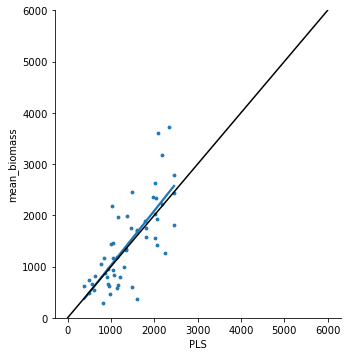

In [21]:
p_obs = sns.lmplot(df,
               x=k, y=y_col, ci=None,
                    scatter_kws={'s': 8, 'alpha': 1, 'edgecolor': None})
for ax in p_obs.axes.flatten():
    ax.set_ylim((0, 6000))
    ax.plot(np.arange(0, 6000), np.arange(0, 6000), c='black')

In [22]:
param_dfs = {}
param_names = list(np.unique([list(x.keys()) for x in mod_dict[k]['tune_results']['params']]))
param_dfs[k] = pd.DataFrame(columns=['Model', 'Best', 'MAE', 'MSE', 'R2', 'R2_train'] + param_names)
df_tmp = pd.DataFrame({'Model': k,
                       'Best': 0,
                       'MAE': mod_dict[k]['tune_results']['mean_test_MAE'],
                       'MSE': mod_dict[k]['tune_results']['mean_test_MSE'],
                       'R2': mod_dict[k]['tune_results']['mean_test_R2'],
                       'R2_train': mod_dict[k]['tune_results']['mean_train_R2']})
for p in param_names:
    df_tmp[p] = mod_dict[k]['tune_results']['param_' + p].data
idx_best = mod_dict[k]['tune_results']['rank_test_MAE'].argmin()
df_tmp.loc[idx_best, 'Best'] = 1
param_dfs[k] = pd.concat([param_dfs[k], df_tmp])

In [23]:
param_dfs

{'PLS':    Model Best       MAE         MSE        R2  R2_train PLS__n_components
 0    PLS    0 -7.789940 -100.157058 -0.041133  0.205610                 1
 1    PLS    0 -7.674323  -88.932990  0.076712  0.334806                 2
 2    PLS    0 -8.202732 -102.117484 -0.071535  0.356040                 3
 3    PLS    0 -7.816831 -100.509236 -0.057177  0.406983                 4
 4    PLS    0 -7.466218  -91.111251  0.054537  0.453280                 5
 5    PLS    0 -7.575766  -85.138229  0.105113  0.498836                 6
 6    PLS    0 -7.527383  -92.371510  0.077083  0.528069                 7
 7    PLS    1 -7.211550  -90.359354  0.073416  0.580500                 8
 8    PLS    0 -7.431032  -92.902330  0.039072  0.598112                 9
 9    PLS    0 -7.408895  -94.169648  0.029353  0.624463                10
 10   PLS    0 -7.646205  -96.587599 -0.032781  0.644756                11
 11   PLS    0 -8.698558 -121.282452 -0.383857  0.675568                12
 12   PLS    0 -8.

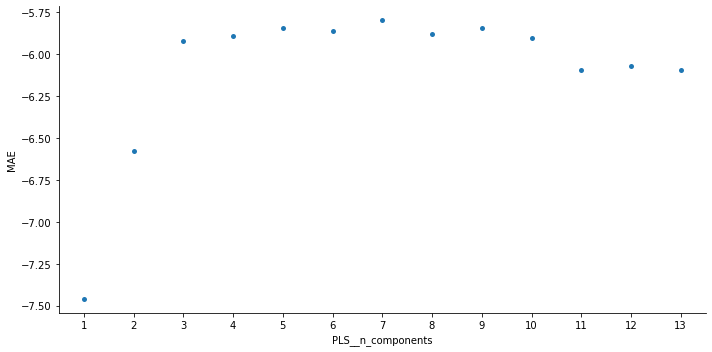

In [36]:
sns.catplot(x='PLS__n_components', y='MAE', data=param_dfs['PLS'], aspect=2)

In [24]:
# sns.catplot(x='LASSO__alpha', y='R2', data=param_dfs['LASSO'], aspect=2)

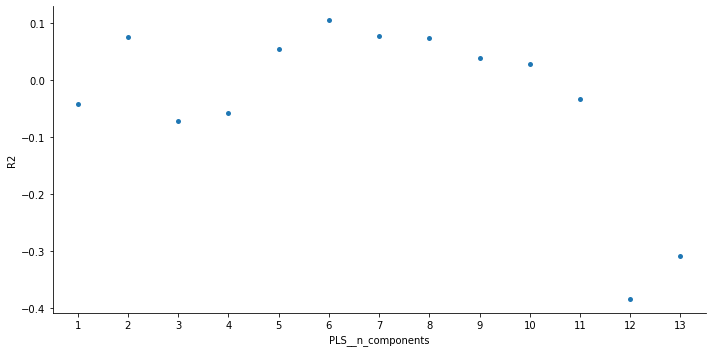

In [25]:
sns.catplot(x='PLS__n_components', y='R2', data=param_dfs['PLS'], aspect=2)

In [26]:
mod_dict[k]['tune_results']['mean_test_MAE'][mod_dict[k]['tune_results']['rank_test_MAE'].argmin()]**2

52.00645763229892

In [27]:
mod_dict[k]['variable_df']

,kfold,Variable,VIP,Coef
0,kfold1,NDVI,0.599715,2.711672
1,kfold1,DFI,0.626620,4.727752
2,kfold1,NDTI,1.065245,2.527004
3,kfold1,SATVI,1.585955,6.276314
4,kfold1,NDII7,0.768803,4.693225
...,...,...,...,...
23,kfold3,GREEN,0.800805,1.759956
24,kfold3,RED,0.635058,0.881411
25,kfold3,NIR1,1.030566,0.940069
26,kfold3,SWIR1,0.682668,0.111844


In [28]:
grid_search.best_score_**2

52.00645763229892

In [29]:
mod_dict[k]['tune_results']['params'][mod_dict[k]['tune_results']['rank_test_R2'].argmin()]

{'PLS__n_components': 6}

In [30]:
grid_search.best_params_

{'PLS__n_components': 8}

In [31]:
mod_dict[k]

{'base_mod': Pipeline(steps=[('scaler', StandardScaler()),
                 ('PLS', PLSRegression(n_components=8, scale=False))]),
 'fit': True,
 'tune': True,
 'tune_vip': False,
 'tune_vip_iters': 3,
 'tune_vip_thresh': [0.8, 0.8, 0.8],
 'variable_importance': True,
 'tune_refit': 'MAE',
 'param_grid': {'PLS__n_components': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13]},
 'tune_results': {'params': [{'PLS__n_components': 1},
   {'PLS__n_components': 2},
   {'PLS__n_components': 3},
   {'PLS__n_components': 4},
   {'PLS__n_components': 5},
   {'PLS__n_components': 6},
   {'PLS__n_components': 7},
   {'PLS__n_components': 8},
   {'PLS__n_components': 9},
   {'PLS__n_components': 10},
   {'PLS__n_components': 11},
   {'PLS__n_components': 12},
   {'PLS__n_components': 13}],
  'mean_fit_time': array([0.01825729, 0.01366565, 0.01971761, 0.13517733, 0.02529567,
         0.02576522, 0.13728483, 0.031046  , 0.02754648, 0.02620916,
         0.13866692, 0.0308

In [32]:
with open(os.path.join(modelDIR, 'results_fnl_' + y_col + '_cv_' + logo_group + '_tuneby_' + tuneby + '.pk'), 'wb') as fp:
    pickle.dump(mod_dict[k], fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(os.path.join(modelDIR, 'mod_fnl_' + y_col + '_cv_' + logo_group + '_tuneby_' + tuneby + '.pk'), 'wb') as fp:
    pickle.dump(mod_fnl, fp, protocol=pickle.HIGHEST_PROTOCOL)